In [1]:
import onnx
import onnxruntime as ort
import numpy as np
import tensorflow as tf
import os
from pathlib import Path
from onnxsim import simplify
import json 
from PIL import Image

2024-05-25 19:07:16.780808: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-25 19:07:16.828919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 19:07:16.828941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 19:07:16.829746: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-25 19:07:16.837491: I tensorflow/core/platform/cpu_feature_guar

In [2]:

# Get the current working directory
current_directory = os.getcwd()

# Print the current working directory
print("Current working directory:", current_directory)
model_dir = "/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/TOP_AMAZON_WORKER/mask_rcnn"
weights_dir = "Bilder-maskrcnn_resnet50_fpn_v2.onnx"

Current working directory: /mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/TOP_AMAZON_WORKER/mask_rcnn


In [3]:
# Assuming checkpoint_path, checkpoint_dir, and colormap_path are strings representing file paths
checkpoint_path = model_dir
checkpoint_dir = checkpoint_path
colormap_path = checkpoint_path
checkpoint_dir_path = checkpoint_path
# Convert the paths to Path objects
checkpoint_path_obj = Path(checkpoint_path)
checkpoint_dir_obj = Path(checkpoint_dir)
colormap_path_obj = Path(colormap_path)

# Set a filename for the ONNX model
onnx_file_path = f"{model_dir}/{weights_dir}"


In [4]:
train_sz = 1024
test_file = '/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/data/Jason_Ad_2.jpg'  # path to test image or from frontend/backend

# Open the test file
test_img = Image.open(test_file).convert('RGB')
# Resize to a specific size
new_size = [train_sz, train_sz]
resized_image = tf.image.resize(test_img, new_size)
resized_image = Image.fromarray(resized_image.numpy().astype(np.uint8))
# Convert the resized image back to PIL format
input_img = tf.keras.preprocessing.image.img_to_array(resized_image)

# Calculate the scale between the source image and the resized image
min_img_scale = min(test_img.size) / min(input_img.shape[:2])

2024-05-25 19:07:18.610598: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 19:07:18.637195: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 19:07:18.637301: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 19:07:18.639622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-25 19:07:18.639667: I external/local_xla/xla/stream_executor

In [5]:
print(checkpoint_dir_obj)

/mnt/c/Users/jason/GitHubRepos/LectorAI-TextExtraction/TOP_AMAZON_WORKER/mask_rcnn


In [6]:
# Find the colormap JSON file in the directory
colormap_path = list(checkpoint_dir_obj.glob('*colormap.json'))[0]

# Load the JSON colormap data
with open(colormap_path, 'r') as file:
    colormap_json = json.load(file)

# Convert the JSON data to a dictionary        
colormap_dict = {item['label']: item['color'] for item in colormap_json['items']}

# Extract the class names from the colormap
class_names = list(colormap_dict.keys())

# Make a copy of the colormap in integer format
int_colors = [tuple(int(c*255) for c in color) for color in colormap_dict.values()]

In [7]:
cropping_params = {
    "ad_erzieher_name":         {"left": 0.15, "bottom": 0},
    "ad_erzieher_vorname":      {"left": 0.15, "bottom": 0},
    "ad_erzieher_tel":          {"left": 0.2, "bottom": 0},
    "ad_erzieher_email":        {"left": 0.15, "bottom": 0},
    "schueler_name":            {"left": 0.15, "bottom": 0},
    "schueler_vorname":         {"left": 0.15, "bottom": 0},
    "schueler_klasse":          {"left": 0.125, "bottom": 0},
    "ad_neue_ad_str_haus_nr":   {"left": 0.275, "bottom": 0},
    "ad_neue_ad_plz":           {"left": 0.25, "bottom": 0},
    "ad_neue_ad_stadt":         {"left": 0.15, "bottom": 0},
    "ad_schueler_datum":        {"left": 0.2, "bottom": 0},
    "ag_auswahl_wahl_1":        {"left": 0.15, "bottom": 0},
    "ag_auswahl_wahl_2":        {"left": 0.15, "bottom": 0},
    "ag_auswahl_wahl_3":        {"left": 0.15, "bottom": 0},
    "ag_schueler_datum":        {"left": 0.3, "bottom": 0},
    "ad_schueler_unterschrift": {"left": 0.2, "bottom": 0}, 
    "ag_schueler_unterschrift": {"left": 0.2, "bottom": 0}, 
}

In [8]:
def adjust_and_crop_images(pred_labels, pred_bboxes, cropping_params, test_img):
    """
    Adjusts bounding boxes based on cropping parameters and crops the images.

    Args:
    pred_labels (list): List of predicted labels.
    pred_bboxes (list): List of predicted bounding boxes.
    cropping_params (dict): Dictionary with cropping parameters. must be adjusted in some images 
    test_img (PIL.Image): The original image to crop.

    Returns:
    list: A list of cropped images.
    """
    cropped_images = []
    
    for label, box in zip(pred_labels, pred_bboxes):
        box = box.astype(int).tolist()  # Convert tensor to list of integers
        if label in cropping_params:
            params = cropping_params[label]
            left_adjust = params.get("left", 0)
            bottom_adjust = params.get("bottom", 0)
            
            # Adjust the bounding box
            box[0] += int((box[2] - box[0]) * left_adjust)
            box[3] -= int((box[3] - box[1]) * bottom_adjust)
        
        cropped_image = test_img.crop((box[0], box[1], box[2], box[3]))
        cropped_images.append(cropped_image)
    
    return cropped_images


In [9]:
def prediction_on_image_inference(test_img, onnx_file_path, class_names, threshold=0.8):
  
    train_sz = 1024

    # Resize the test image
    input_img = tf.image.resize(test_img, [train_sz, train_sz])

     # Convert the resized image to a tensor
    input_tensor = tf.convert_to_tensor(input_img)

    # Add a batch dimension to the input tensor
    input_tensor = tf.expand_dims(input_tensor, axis=0)

    # Calculate the scale between the source image and the resized image
    min_img_scale = min(test_img.size) / min(input_img.shape[:2])    
    # Load the model and create an InferenceSession
    session = ort.InferenceSession(onnx_file_path, providers=['CPUExecutionProvider'])

    # Transpose the input tensor to match the expected format 
    input_tensor = tf.transpose(input_tensor, perm=[0, 3, 1, 2])  
    input_tensor = input_tensor.numpy().astype(np.float32) / 255.0
    
    model_output = session.run(None, {"input": input_tensor})

    # Filter the output based on the confidence threshold
    scores_mask = model_output[2] > threshold
    
    label_list = [class_names[int(idx)] for idx in model_output[1][scores_mask]]

    # Scale the predicted bounding boxes
    pred_bboxes = (model_output[0][scores_mask])*min_img_scale

    # Get the class names for the predicted label indices
    pred_labels = [class_names[int(idx)] for idx in model_output[1][scores_mask]]

    # Extract the confidence scores
    pred_scores = model_output[2]
    
    colors = [int_colors[class_names.index(i)] for i in label_list]

    # Adjust and crop the images based on the bounding boxes and cropping parameters
    cropped_images = adjust_and_crop_images(pred_labels, pred_bboxes, cropping_params, test_img)

    # Combine the bounding boxes, cropped images, labels, and confidence scores
    results = []
    for label, box, image, score in zip(pred_labels, pred_bboxes, cropped_images, pred_scores):
        results.append((label, box, image, score.item()))

    return results


In [10]:
results = prediction_on_image_inference(test_img, onnx_file_path, class_names)

2024-05-25 19:07:20.908183663 [W:onnxruntime:, graph.cc:4093 CleanUnusedInitializersAndNodeArgs] Removing initializer '3114'. It is not used by any node and should be removed from the model.


Label: schueler, Box: [ 314.6062   802.2611  1173.3313   984.78094], Confidence: 0.9994145631790161


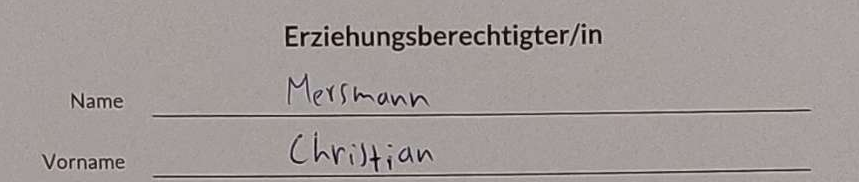

Label: ad_erzieher_name, Box: [ 364.90994  607.84753 1135.4962   649.9675 ], Confidence: 0.9992037415504456


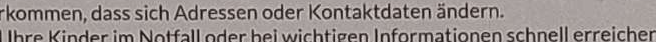

Label: ad_neue_ad, Box: [ 203.10822  995.55646 1183.9218  1184.4806 ], Confidence: 0.9986648559570312


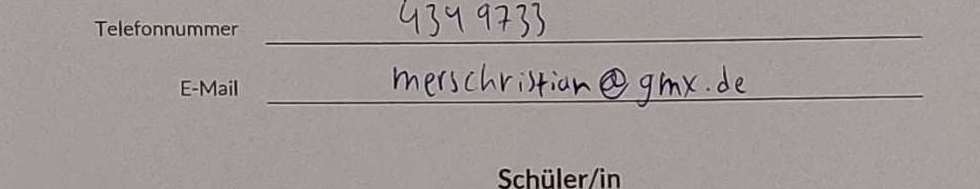

Label: ad_erzieher_tel, Box: [ 293.08032  694.99335 1140.5223   734.0849 ], Confidence: 0.9986435770988464


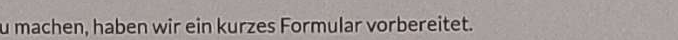

Label: ad_erzieher, Box: [ 281.7279   561.9068  1166.9257   789.37024], Confidence: 0.9985501170158386


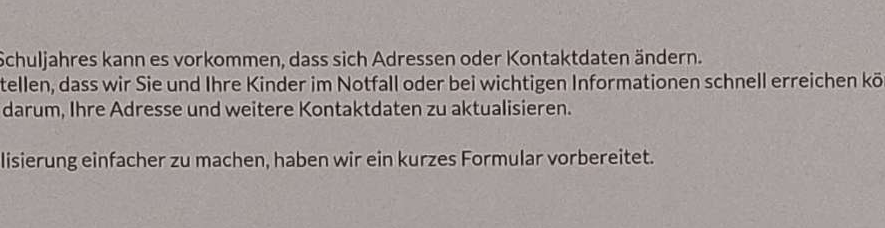

Label: ad_erzieher_email, Box: [ 361.18292  736.5877  1128.1172   779.1959 ], Confidence: 0.9982923865318298


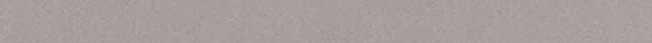

Label: schueler_klasse, Box: [ 377.68018  928.6233  1128.2056   972.2849 ], Confidence: 0.9982535243034363


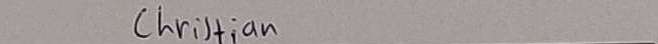

Label: ad_neue_ad_plz, Box: [ 336.34988 1075.9012  1135.4062  1115.723  ], Confidence: 0.9978724718093872


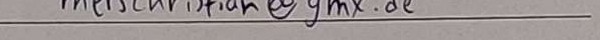

Label: ad_schueler_datum, Box: [1059.3589 1293.3982 1386.4246 1360.1884], Confidence: 0.9965351819992065


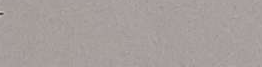

Label: ad_neue_ad_stadt, Box: [ 390.9613 1116.4723 1128.6516 1163.6282], Confidence: 0.9963911175727844


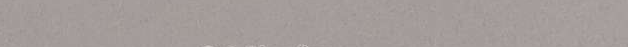

Label: ad_neue_ad_str_haus_nr, Box: [ 219.08809 1029.306   1143.0284  1073.2251 ], Confidence: 0.9958730340003967


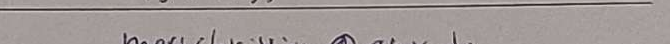

Label: schueler_name, Box: [ 375.55188  841.97473 1136.0636   886.2492 ], Confidence: 0.9953613877296448


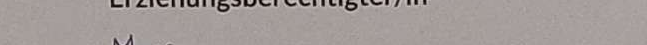

Label: adress_aend, Box: [ 315.83133  293.03262 1201.9843   368.19214], Confidence: 0.9950954914093018


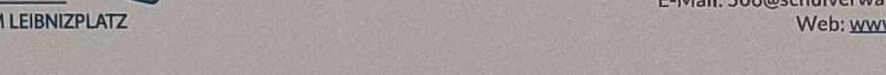

Label: ad_unterschrift, Box: [ 309.40082 1288.9563  1406.0906  1382.9808 ], Confidence: 0.9947303533554077


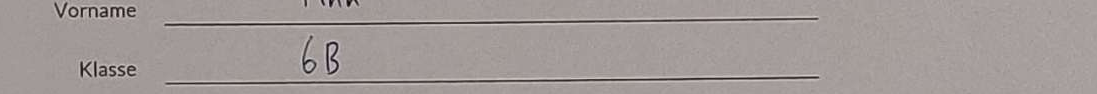

Label: ad_erzieher_vorname, Box: [ 346.95456  652.2267  1129.9517   691.2098 ], Confidence: 0.9938073754310608


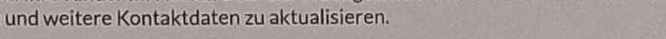

Label: schueler_vorname, Box: [ 348.5616   884.31775 1139.4794   925.3921 ], Confidence: 0.9921107888221741


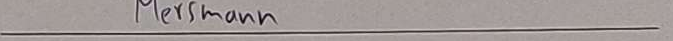

Label: ad_schueler_unterschrift, Box: [ 339.2653 1299.0024  906.6553 1379.8762], Confidence: 0.9893712997436523


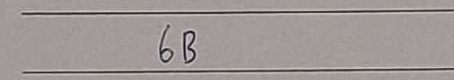

In [11]:
# Display the results
for label, box, image, score in results:
    print(f"Label: {label}, Box: {box}, Confidence: {score}")
    image.show()

In [12]:
results

[('schueler',
  array([ 314.6062 ,  802.2611 , 1173.3313 ,  984.78094], dtype=float32),
  <PIL.Image.Image image mode=RGB size=859x182>,
  0.9994145631790161),
 ('ad_erzieher_name',
  array([ 364.90994,  607.84753, 1135.4962 ,  649.9675 ], dtype=float32),
  <PIL.Image.Image image mode=RGB size=656x42>,
  0.9992037415504456),
 ('ad_neue_ad',
  array([ 203.10822,  995.55646, 1183.9218 , 1184.4806 ], dtype=float32),
  <PIL.Image.Image image mode=RGB size=980x189>,
  0.9986648559570312),
 ('ad_erzieher_tel',
  array([ 293.08032,  694.99335, 1140.5223 ,  734.0849 ], dtype=float32),
  <PIL.Image.Image image mode=RGB size=678x40>,
  0.9986435770988464),
 ('ad_erzieher',
  array([ 281.7279 ,  561.9068 , 1166.9257 ,  789.37024], dtype=float32),
  <PIL.Image.Image image mode=RGB size=885x228>,
  0.9985501170158386),
 ('ad_erzieher_email',
  array([ 361.18292,  736.5877 , 1128.1172 ,  779.1959 ], dtype=float32),
  <PIL.Image.Image image mode=RGB size=652x43>,
  0.9982923865318298),
 ('schueler_kl